# **News Genre Dataset**

In this notebook we explore the dataset used for news genre classification, but firstly we need to get the dataset that is publicly available [here](https://github.com/nitanshjain/news_genre_classification_semeval_2023/blob/main/semeval2023task3/subtask1/data/preprocessed_data.zip).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
nltk.download('punkt_tab')
import spacy
nlp = spacy.load("en_core_web_sm")

from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


##### **Dataset Loading**

In [2]:
!wget https://raw.githubusercontent.com/nitanshjain/news_genre_classification_semeval_2023/main/semeval2023task3/subtask1/data/preprocessed_data.zip -O preprocessed_data.zip
!unzip preprocessed_data.zip -d data

--2026-01-19 12:40:15--  https://raw.githubusercontent.com/nitanshjain/news_genre_classification_semeval_2023/main/semeval2023task3/subtask1/data/preprocessed_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28683215 (27M) [application/zip]
Saving to: ‘preprocessed_data.zip’

preprocessed_data.z 100%[===================>]  27.35M  --.-KB/s    in 0.1s    

2026-01-19 12:40:16 (205 MB/s) - ‘preprocessed_data.zip’ saved [28683215/28683215]

Archive:  preprocessed_data.zip
   creating: data/preprocessed_data/
  inflating: data/preprocessed_data/.DS_Store  
  inflating: data/__MACOSX/preprocessed_data/._.DS_Store  
   creating: data/preprocessed_data/subtask1_with_numbers/
   creating: data/preprocessed_data/subtask1_without_numbers/
  inflating: data/pre

In [3]:
path_to_articles_en = "data/preprocessed_data/subtask1_with_numbers"
train_path = f"{path_to_articles_en}/en_train_subtask_1.csv"
dev_path = f"{path_to_articles_en}/en_dev_subtask_1.csv"
test_path = f"{path_to_articles_en}/en_test_subtask_1.csv"

In [4]:
train_data = pd.read_csv(train_path)
dev_data = pd.read_csv(dev_path)
test_data = pd.read_csv(test_path)

## **Exploratory Data Analysis**

##### **Class distribution analysis**

In [5]:
print("Number of articles per set:")
print("---------------------------")
print(f"TRAIN: {len(train_data)}")
print(f"DEV: {len(dev_data)}")
print(f"TEST: {len(test_data)}")

Number of articles per set:
---------------------------
TRAIN: 433
DEV: 83
TEST: 54


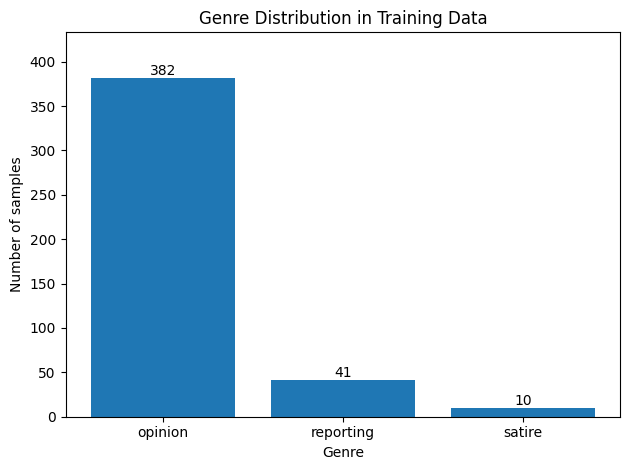

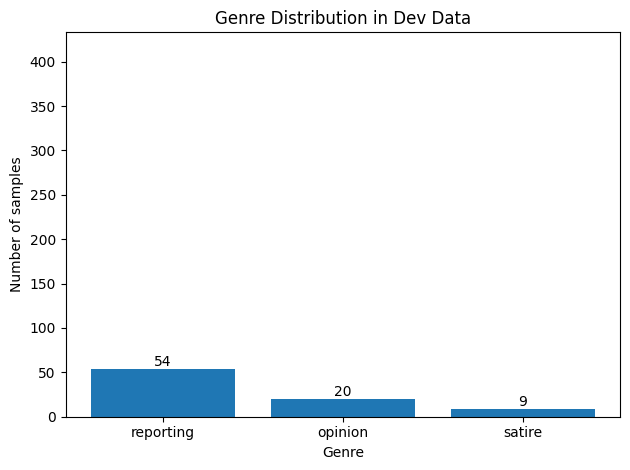

In [6]:
def genre_distribution(distribution: pd.Series, title: str) ->  None:
  plt.figure()
  bars = plt.bar(distribution.index, distribution.values)
  plt.xlabel("Genre")
  plt.ylabel("Number of samples")
  plt.title(title)
  plt.xticks(rotation=0)
  plt.ylim(0, len(train_data))

  for bar in bars:
      height = bar.get_height()
      plt.text(
          bar.get_x() + bar.get_width() / 2,
          height,
          str(height),
          ha="center",
          va="bottom"
      )

  plt.tight_layout()
  plt.show()

# extract the genre distribution for train data
genre_train_distribution = train_data["genre"].value_counts()
genre_distribution(genre_train_distribution, "Genre Distribution in Training Data")
# extract the genre distribution for dev data
genre_dev_distribution = dev_data["genre"].value_counts()
genre_distribution(genre_dev_distribution, "Genre Distribution in Dev Data")

Because the number of *reporting* and *satire* news is very small compared to the number of *opinion* articles, the train and dev datasets will be merged.

In [7]:
train_data = pd.concat([train_data, dev_data])

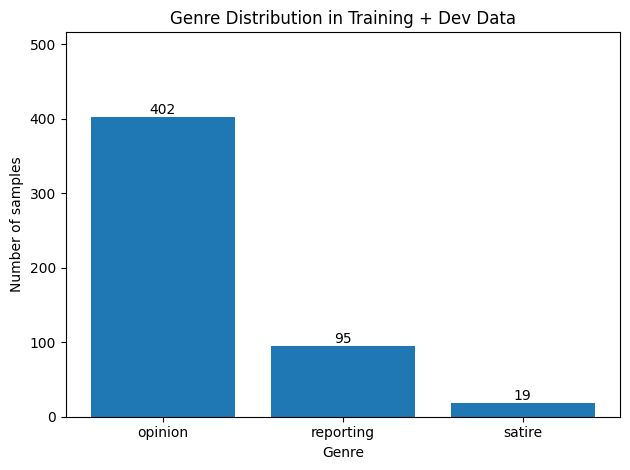

In [8]:
# extract the genre distribution for train data
genre_train_distribution = train_data["genre"].value_counts()
genre_distribution(genre_train_distribution, "Genre Distribution in Training + Dev Data")

##### **Words and vocabulary analysis**

In [9]:
genres = train_data["genre"].unique()
genre_word_stats = {genre: {} for genre in genres}

for genre in genre_word_stats:
  # extract the indexes for the current genre
  articles = train_data.loc[train_data["genre"] == genre, "articles"]
  total_words = 0
  vocabulary = Counter()

  for i, article in enumerate(articles):
    words = word_tokenize(article)
    words = [word for word in words if word not in string.punctuation]

    # add the to the total number of words
    total_words += len(words)
    vocabulary.update(words)

  # compute sentence and vocabulary stats
  genre_word_stats[genre]["total_words"] = total_words
  genre_word_stats[genre]["vocabulary_size"] = len(vocabulary)
  genre_word_stats[genre]["avg_words_per_article"] = (
      total_words / len(articles) if len(articles) > 0 else 0
  )
  genre_word_stats[genre]["avg_words_per_article"] = round(genre_word_stats[genre]["avg_words_per_article"], 4)

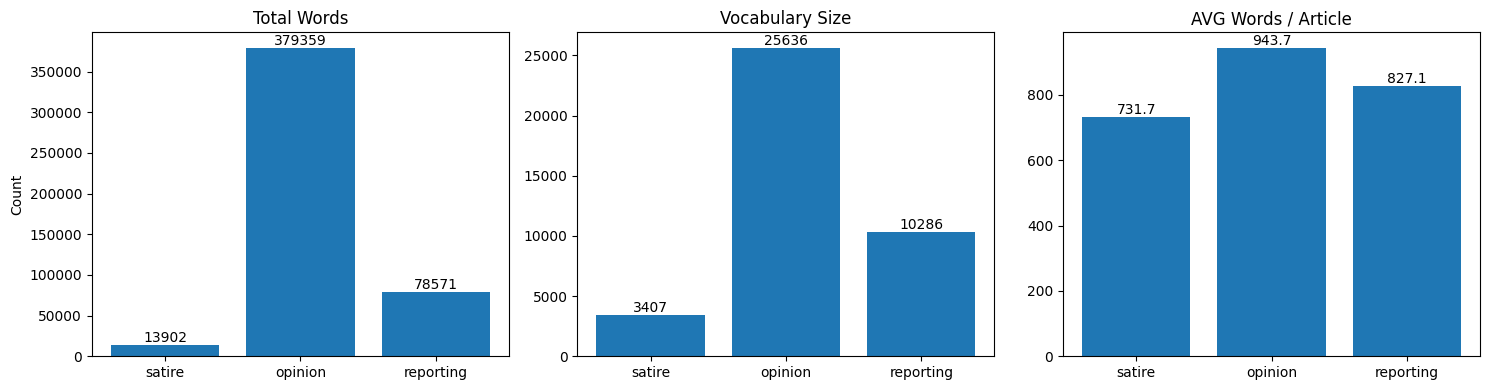

In [10]:
# extract the stats per category as lists
total_words = [genre_word_stats[g]["total_words"] for g in genres]
vocabulary_sizes = [genre_word_stats[g]["vocabulary_size"] for g in genres]
avg_words_per_article = [genre_word_stats[g]["avg_words_per_article"] for g in genres]

def add_labels(ax, values):
    for i, v in enumerate(values):
        ax.text(i, v, f"{v:.1f}" if isinstance(v, float) else str(v),
                ha="center", va="bottom")

x = np.arange(len(genres))
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# total words
axes[0].bar(x, total_words)
axes[0].set_title("Total Words")
axes[0].set_xticks(x)
axes[0].set_xticklabels(genres)
axes[0].set_ylabel("Count")
add_labels(axes[0], total_words)

# vocabulary size
axes[1].bar(x, vocabulary_sizes)
axes[1].set_title("Vocabulary Size")
axes[1].set_xticks(x)
axes[1].set_xticklabels(genres)
add_labels(axes[1], vocabulary_sizes)

# avg words per article
axes[2].bar(x, avg_words_per_article)
axes[2].set_title("AVG Words / Article")
axes[2].set_xticks(x)
axes[2].set_xticklabels(genres)
add_labels(axes[2], avg_words_per_article)

plt.tight_layout()
plt.show()


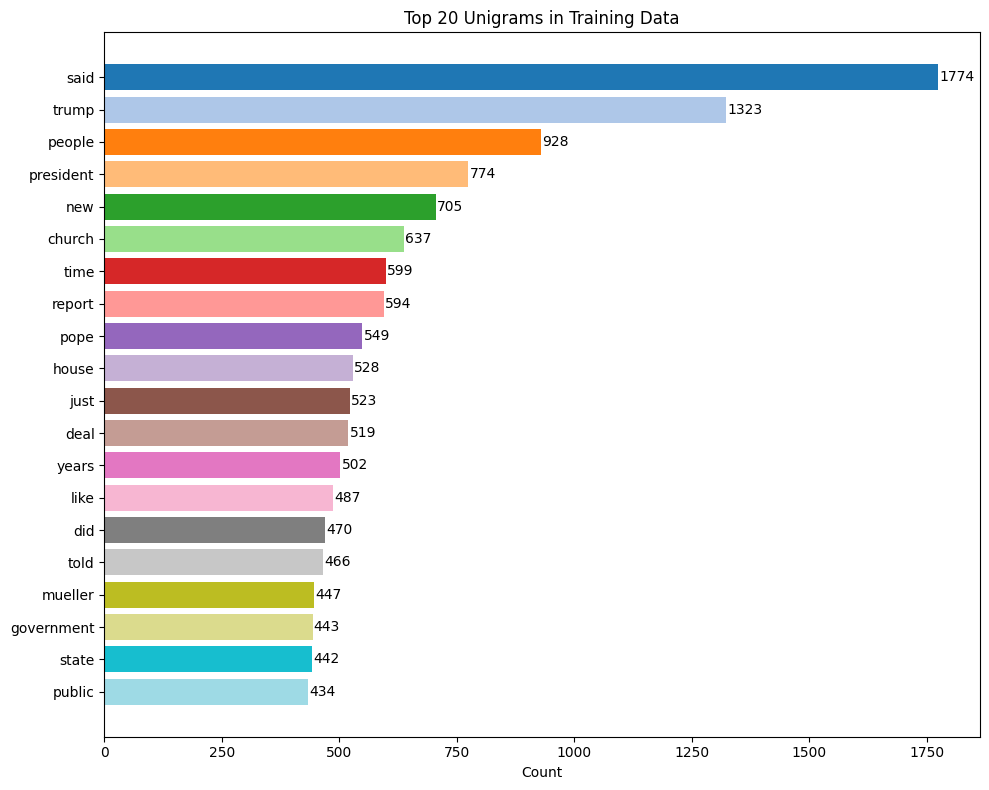

In [11]:
# top 20 unigrams computation
uni_vectorizer = CountVectorizer(lowercase=True, stop_words="english")
X_uni = uni_vectorizer.fit_transform(train_data["articles"].values)
uni_counts = np.array(X_uni.sum(axis=0)).flatten()
uni_vocab = np.array(uni_vectorizer.get_feature_names_out())

top20_uni_idx = uni_counts.argsort()[-20:][::-1]
top20_unigrams = list(zip(uni_vocab[top20_uni_idx], uni_counts[top20_uni_idx]))

# plot the unigrams as horizontal bar charts
words, counts = zip(*top20_unigrams)
y_pos = np.arange(len(words))
colors = plt.cm.tab20.colors
colors = colors[:len(words)]

plt.figure(figsize=(10, 8))
plt.barh(y_pos, counts, color=colors)
plt.yticks(y_pos, words)
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title("Top 20 Unigrams in Training Data")

for i, v in enumerate(counts):
    plt.text(v + 2.5, i, str(v), va='center')

plt.tight_layout()
plt.show()

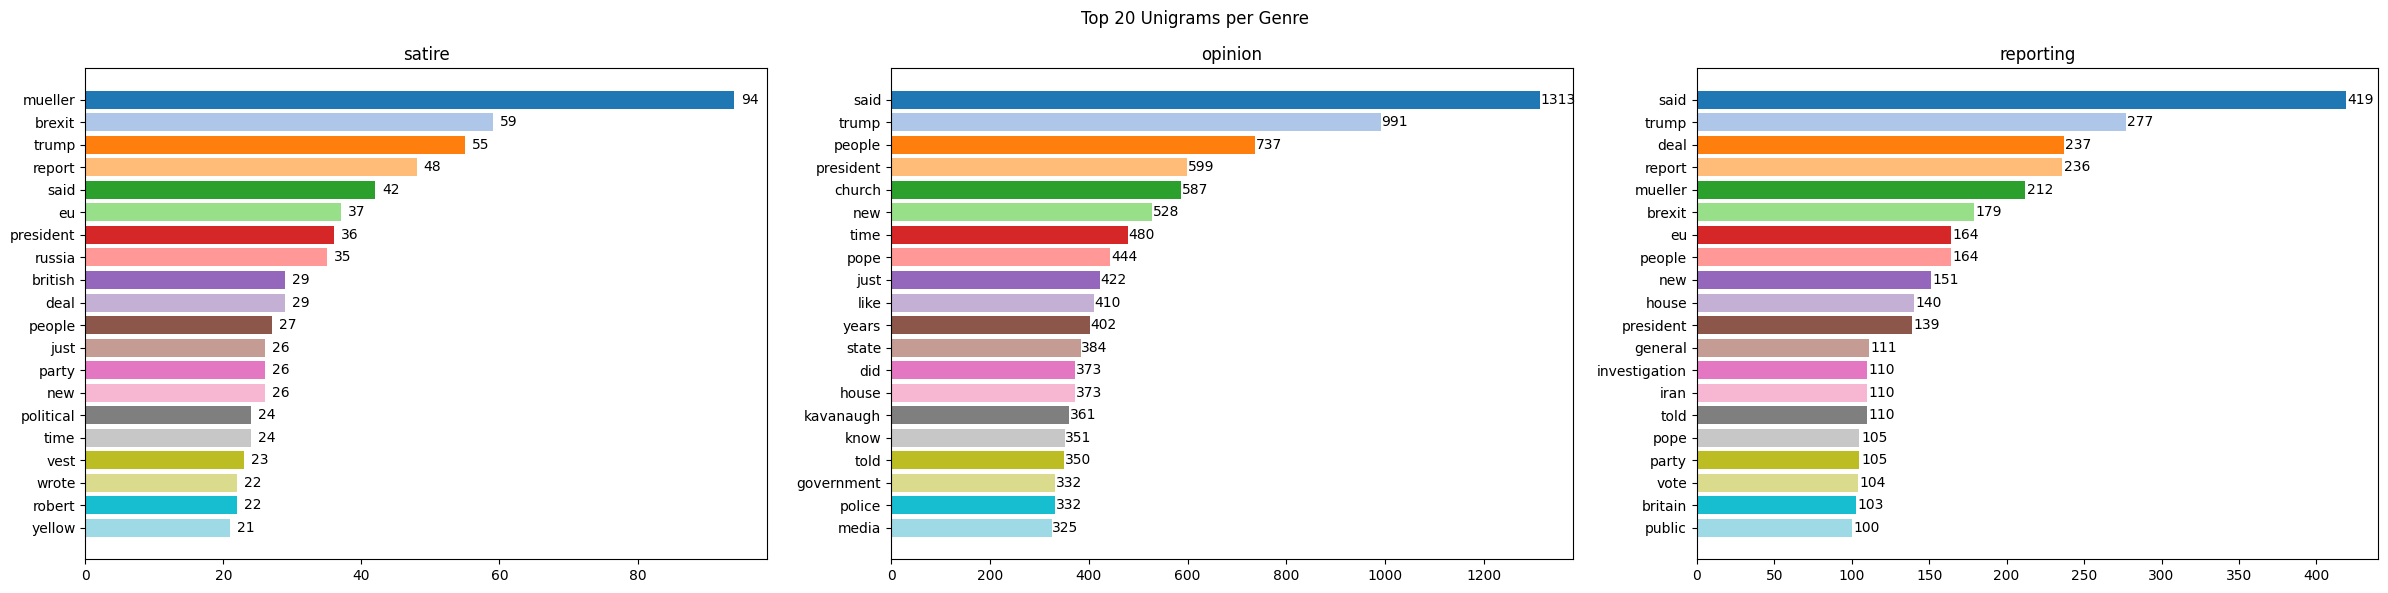

In [12]:
fig, axes = plt.subplots(1, len(genres), figsize=(24, 6))

for i, genre in enumerate(genres):
    texts = train_data.loc[train_data["genre"] == genre, "articles"].values
    vectorizer = CountVectorizer(lowercase=True, stop_words="english")
    X = vectorizer.fit_transform(texts)
    counts = np.array(X.sum(axis=0)).flatten()
    vocab = np.array(vectorizer.get_feature_names_out())

    top_idx = counts.argsort()[-20:][::-1]
    top_words = vocab[top_idx]
    top_counts = counts[top_idx]

    y_pos = np.arange(len(top_words))
    colors = plt.cm.tab20.colors[:len(top_words)]

    axes[i].barh(y_pos, top_counts, color=colors)
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(top_words)
    axes[i].invert_yaxis()
    axes[i].set_title(genre)

    # Add count labels
    for j, v in enumerate(top_counts):
        axes[i].text(v + 1, j, str(v), va='center')

plt.suptitle("Top 20 Unigrams per Genre")
plt.tight_layout()
plt.show()


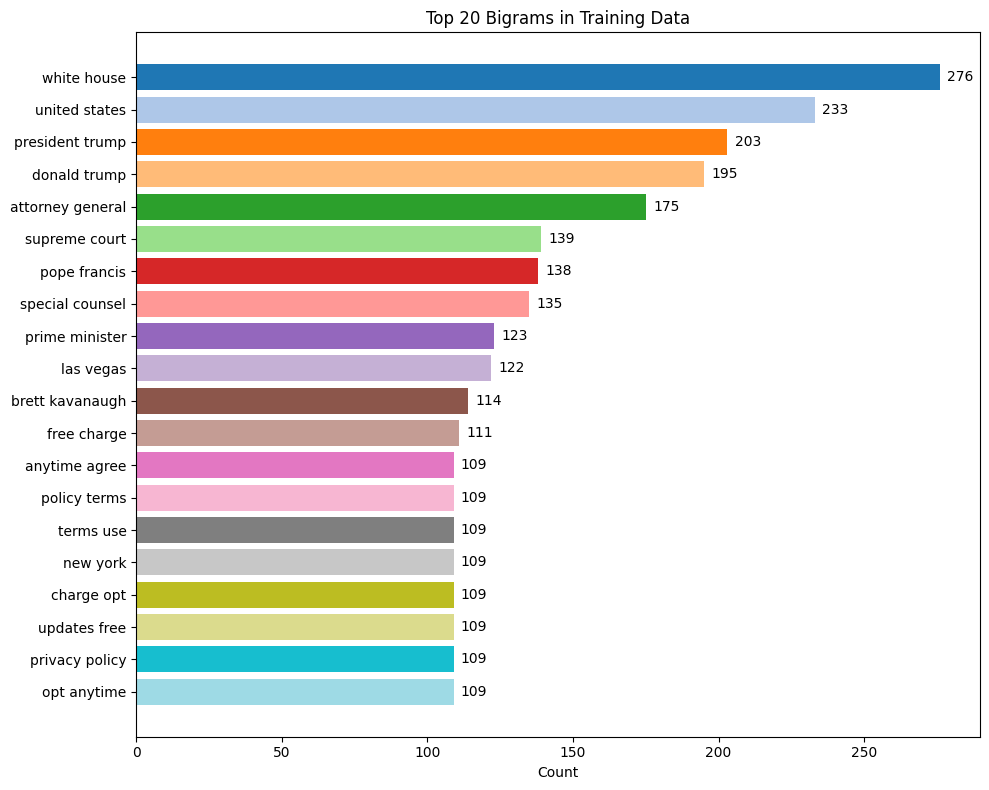

In [13]:
# top 20 bigrams
bi_vectorizer = CountVectorizer(lowercase=True, stop_words="english", ngram_range=(2, 2))
X_bi = bi_vectorizer.fit_transform(train_data["articles"].values)
bi_counts = np.array(X_bi.sum(axis=0)).flatten()
bi_vocab = np.array(bi_vectorizer.get_feature_names_out())

top20_bi_idx = bi_counts.argsort()[-20:][::-1]
top20_bigrams = list(zip(bi_vocab[top20_bi_idx], bi_counts[top20_bi_idx]))

# plot the unigrams as horizontal bar charts
words, counts = zip(*top20_bigrams)
y_pos = np.arange(len(words))
colors = plt.cm.tab20.colors
colors = colors[:len(words)]

plt.figure(figsize=(10, 8))
plt.barh(y_pos, counts, color=colors)
plt.yticks(y_pos, words)
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title("Top 20 Bigrams in Training Data")

for i, v in enumerate(counts):
    plt.text(v + 2.5, i, str(v), va='center')

plt.tight_layout()
plt.show()


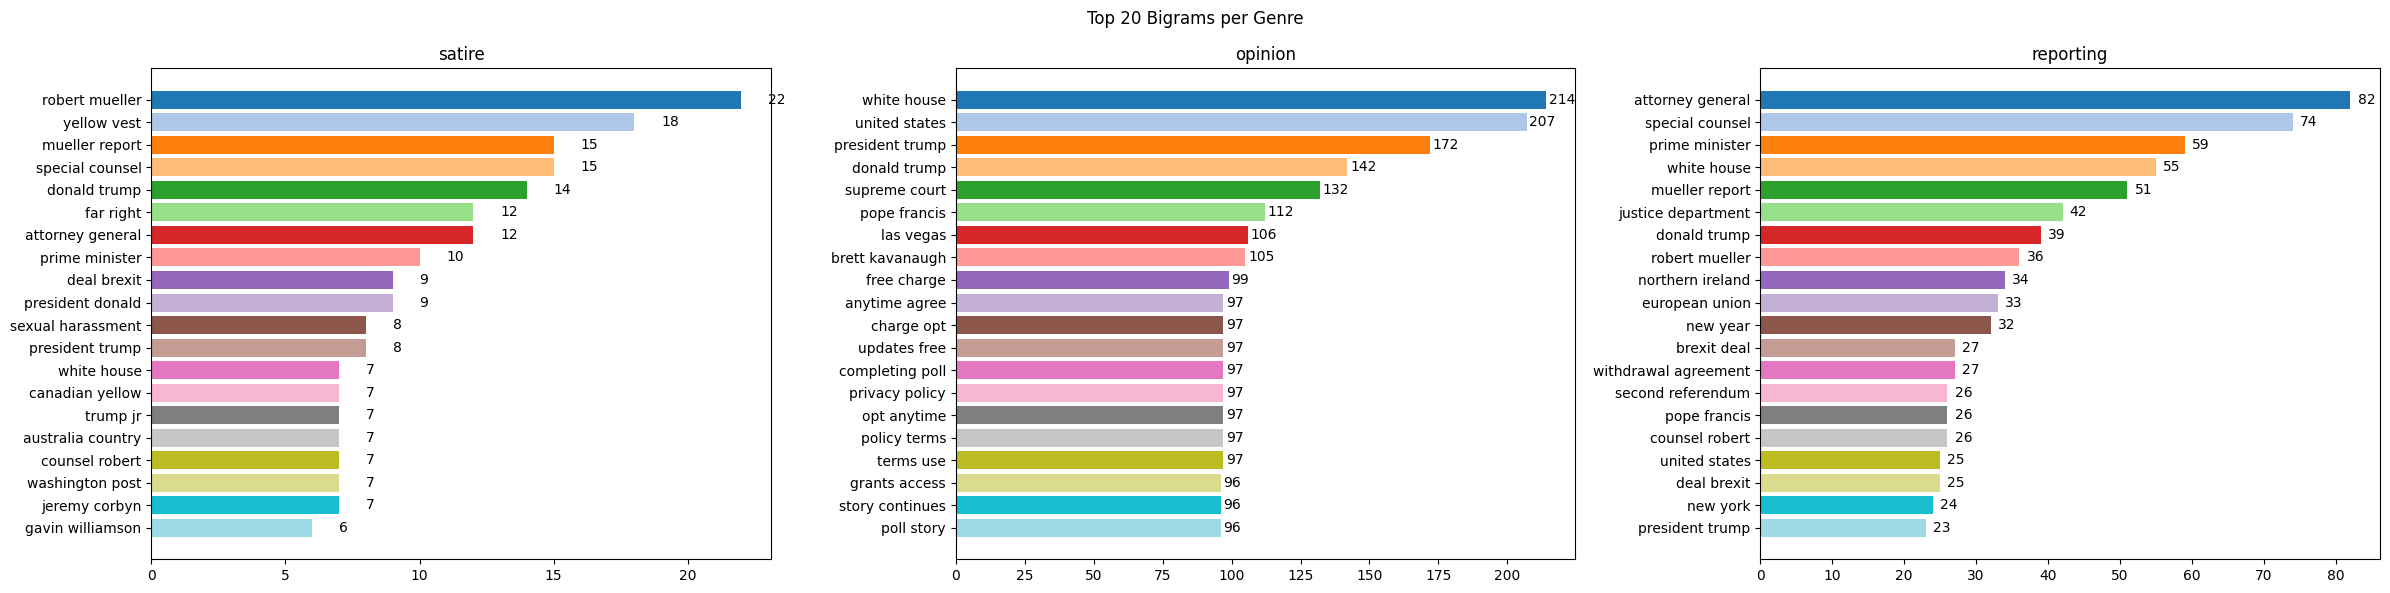

In [14]:
fig, axes = plt.subplots(1, len(genres), figsize=(24, 6))

for i, genre in enumerate(genres):
    texts = train_data.loc[train_data["genre"] == genre, "articles"].values
    vectorizer = CountVectorizer(lowercase=True, stop_words="english", ngram_range=(2, 2))
    X = vectorizer.fit_transform(texts)
    counts = np.array(X.sum(axis=0)).flatten()
    vocab = np.array(vectorizer.get_feature_names_out())

    top_idx = counts.argsort()[-20:][::-1]
    top_words = vocab[top_idx]
    top_counts = counts[top_idx]

    y_pos = np.arange(len(top_words))
    colors = plt.cm.tab20.colors[:len(top_words)]

    axes[i].barh(y_pos, top_counts, color=colors)
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(top_words)
    axes[i].invert_yaxis()
    axes[i].set_title(genre)

    # Add count labels
    for j, v in enumerate(top_counts):
        axes[i].text(v + 1, j, str(v), va='center')

plt.suptitle("Top 20 Bigrams per Genre")
plt.tight_layout()
plt.show()


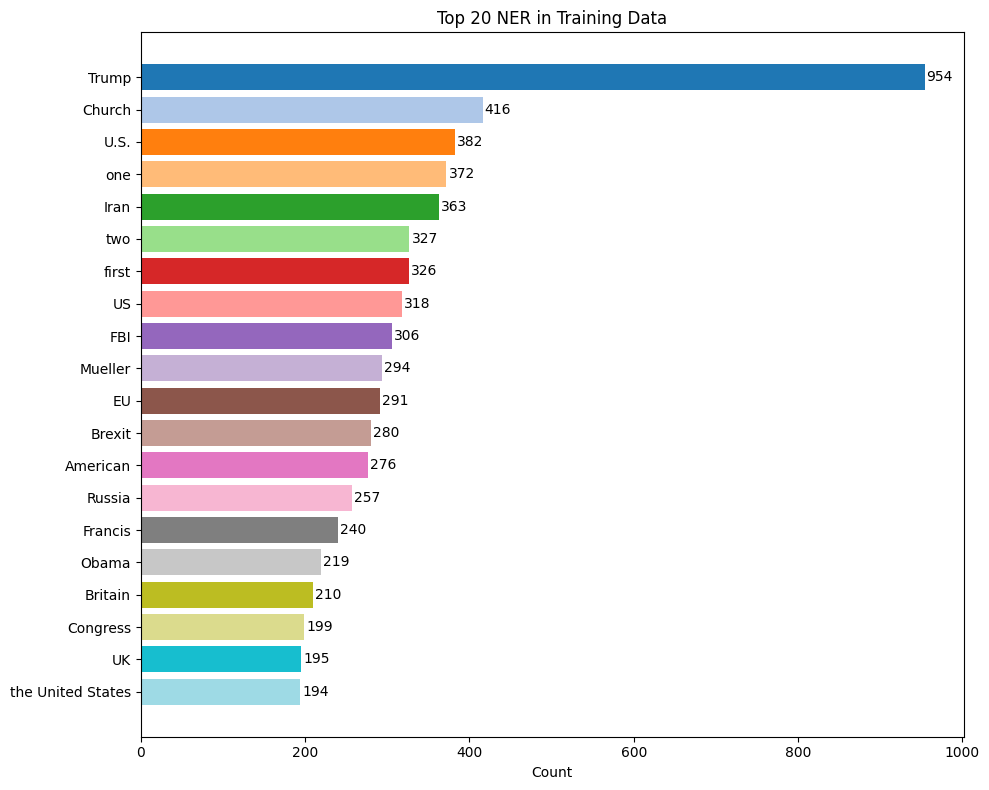

In [15]:
ner_counter = Counter()

for doc in nlp.pipe(train_data["articles"].values, batch_size=50, disable=["tagger", "parser", "lemmatizer"]):
    ner_counter.update([ent.text for ent in doc.ents])

top20_ner = ner_counter.most_common(20)

# plot the unigrams as horizontal bar charts
words, counts = zip(*top20_ner)
y_pos = np.arange(len(words))
colors = plt.cm.tab20.colors
colors = colors[:len(words)]

plt.figure(figsize=(10, 8))
plt.barh(y_pos, counts, color=colors)
plt.yticks(y_pos, words)
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title("Top 20 NER in Training Data")

for i, v in enumerate(counts):
    plt.text(v + 2.5, i, str(v), va='center')

plt.tight_layout()
plt.show()


## **Dataset Simplification**

In [17]:
train_data_simplified = train_data[["id", "genre", "headlines", "articles"]]
train_data_simplified["full_articles"] = (
    "Title: " + train_data_simplified["headlines"] + " Content: " + train_data_simplified["articles"]
)
train_data_simplified

/tmp/ipython-input-1699300693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_simplified["full_articles"] = (


,id,genre,headlines,articles,full_articles
0,833042063,satire,Chelsea Handler Admits She’s ‘Very Sexually At...,Far-left comedienne Chelsea Handler has admitt...,Title: Chelsea Handler Admits She’s ‘Very Sexu...
1,832959523,satire,How Theresa May Botched\n,Those were the times…\nThe Times page 1 is of ...,Title: How Theresa May Botched\n Content: Thos...
2,833039623,satire,Robert Mueller III Rests His Case—Dems NEVER W...,Carload of crazies headed to the White House w...,Title: Robert Mueller III Rests His Case—Dems ...
3,833032367,satire,Robert Mueller Not Recommending Any More Indic...,"But of course, this makes no difference to the...",Title: Robert Mueller Not Recommending Any Mor...
4,814777937,satire,The Far Right Is Trying to Co-opt the Yellow V...,"This weekend in Manchester, England, Yellow Ve...",Title: The Far Right Is Trying to Co-opt the Y...
...,...,...,...,...,...
78,829815104,opinion,Brussels Shows Its Fear\n,Hungarian Prime Minister Viktor Orban has been...,Title: Brussels Shows Its Fear\n Content: Hung...
79,817147979,opinion,BREXIT OR BRINO: U.K.\n,Deep State Strikes Back—And Misses.\nGood Omen...,Title: BREXIT OR BRINO: U.K.\n Content: Deep S...
80,813623212,reporting,'Wishful thinking': Tory MPs dismiss May's hop...,Jeremy Hunt insisted Theresa May can still sal...,Title: 'Wishful thinking': Tory MPs dismiss Ma...
81,832948083,reporting,Mueller concludes Russia-Trump probe; lawmaker...,Mueller concludes Russia-Trump probe; lawmaker...,Title: Mueller concludes Russia-Trump probe; l...


In [19]:
train_data_simplified.to_csv("articles_en.csv")